In [ ]:
# Autor: Luiz Felipe Barro Alves
# data: 21/04/2025

# $$\text{INFORMAÇÕES SOBRE O CÓDIGO:}$$
- ## Cada célula deste código descreve e executa cada uma das etapas necessárias para a implementação da atividade.

In [1]:
# Bibliotecas utilizadas
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.io import wavfile
import scipy.signal as sig

# Sinal de áudio

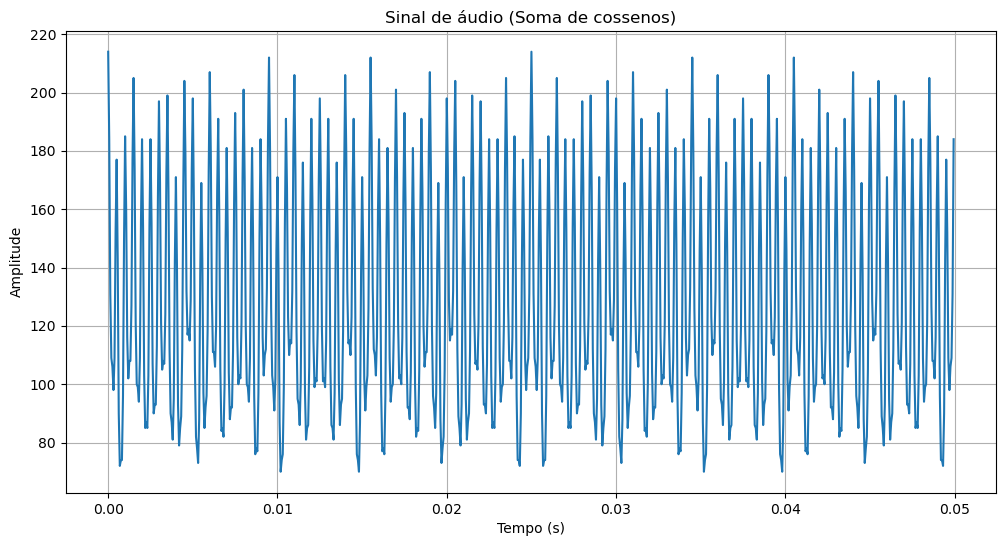

In [2]:
sample_rate, data = wavfile.read('sinal_1.wav')

time  = np.linspace(0.0, (1/sample_rate)*len(data), len(data))
visual_time = 0.05 # Tempo de visualização, pois há muitas amostras para plotar
n_samples = int(sample_rate * visual_time) # Quantidade de amostras a serem plotadas

plt.figure(figsize=(12, 6))
plt.plot(time[:n_samples], data[:n_samples])
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title("Sinal de áudio (Soma de cossenos)")
plt.grid()
plt.show()

# Determinando as componentes de frequência via FFT da biblioteca numpy

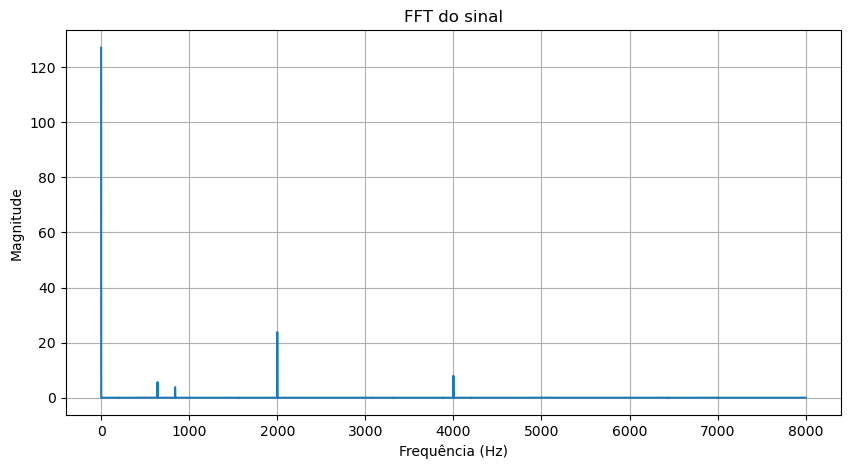

In [22]:
N = len(data)

# Calculando a FFT
fft_result = np.fft.fft(data)
fft_freqs = np.fft.fftfreq(N, d=1/sample_rate)

# Pegando apenas a parte positiva da FFT (por simetria)
half_N = N // 2
fft_freqs = fft_freqs[:half_N]
fft_magnitude = np.abs(fft_result[:half_N]) / N  
# Plot
plt.figure(figsize=(10, 5))
plt.plot(fft_freqs, fft_magnitude)
plt.title('FFT do sinal')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()


In [23]:
# Índices das 6 maiores amplitudes
top5_idx = np.argsort(fft_magnitude)[-6:]

# Frequências correspondentes
top5_freqs = fft_freqs[top5_idx]
top5_mags = fft_magnitude[top5_idx]

# Exibindo os resultados
for f, m in zip(top5_freqs, top5_mags):
    print(f'Frequência: {f:.2f} Hz, Magnitude: {m:.3f}')


Frequência: 839.99 Hz, Magnitude: 3.853
Frequência: 640.03 Hz, Magnitude: 4.428
Frequência: 639.98 Hz, Magnitude: 5.644
Frequência: 4000.00 Hz, Magnitude: 7.951
Frequência: 2000.00 Hz, Magnitude: 23.821
Frequência: 0.00 Hz, Magnitude: 127.029


# Determinando as componentes de frequência via DFT implementada na disciplina

In [24]:
N = 2**10 # Tamanho da DFT

k = np.array([np.arange(0, N)]) # Número de amostras
n = np.arange(0, N) # Índice do somatório
k_T = k.reshape(-1, 1) # Número de amostras organizadas como uma matriz Nx1

In [25]:
func = data[:N]
func_T = func.reshape(-1, 1) # Amostras organizadas como uma matriz Nx1

Wn = np.exp(-2j*np.pi/N) # Definição de Wn

M_result = Wn**(k_T*n) # Matriz com as exponenciais complexas

DFT = M_result @ func_T

<>:9: SyntaxWarning: invalid escape sequence '\O'
<>:9: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_21505/3260303011.py:9: SyntaxWarning: invalid escape sequence '\O'
  axs.set_xlabel('$|\Omega[k]$')


[Text(0.0, 0, '0'),
 Text(0.7853981633974483, 0, '$\\pi/4$'),
 Text(1.5707963267948966, 0, '$\\pi/2$'),
 Text(2.356194490192345, 0, '$3\\pi/4$'),
 Text(3.141592653589793, 0, '$\\pi$')]

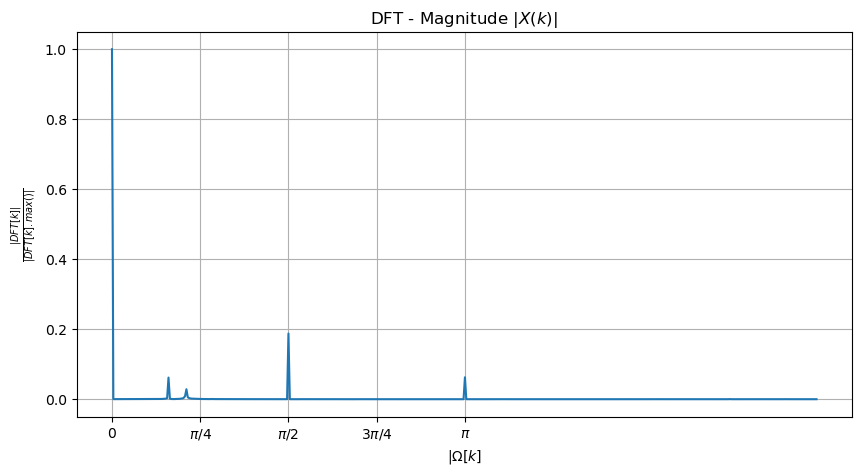

In [26]:
xticks = [0, np.pi/4, np.pi/2, (3*np.pi)/4, np.pi]
xticklabels = ['0', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$']
# Pegando apenas a parte positiva da FFT (por simetria)
half_N = N // 2

fig, axs  = plt.subplots(1, 1, figsize=(10,5))

axs.plot(2*np.pi*k_T[:half_N]/half_N, np.abs(DFT[:half_N])/np.abs(DFT.max()))
axs.set_xlabel('$|\Omega[k]$')
axs.set_ylabel(r'$\frac{|DFT[k]|}{|DFT[k].max()|}$')
axs.grid()
axs.set_title('DFT - Magnitude |$X(k)$|')
axs.set_xticks(xticks)
axs.set_xticklabels(xticklabels)
# axs.set_ylim([0,0.029])

## Frequência de cada componente

In [167]:
amplitude = abs(DFT.flatten())/abs(DFT.max())
DFT_freq = np.array([])
j = 0
for i in amplitude[:N//2]:
    if (i >= 0.027):
        DFT_freq = np.append(DFT_freq, (j/N)*sample_rate)
    j += 1
print('Frequência de cada componente:', DFT_freq,'Hz')

Frequência de cada componente: [   0.     640.625  843.75  2000.    4000.   ] Hz


# Aplicação de Filtros de Resposta Infinita ao Impulso (IIR) para separar os cossenos do sinal de áudio

As referência para esse projeto podem ser encontradas em:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ellip.html
- https://www.geeksforgeeks.org/design-iir-bandpass-elliptic-filter-using-scipy-python/
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html

In [3]:
# Componentes de frequência do sinal:
frequencias = np.array([640, 840, 2000, 4000]) # Hz

In [4]:
# Função para plotar a resposta em frequência dos filtros
def Response_freq_IIR(freq, b, a, sample_rate, band, edges, figsize=(10,5), zoom = 40):

    wz, hz = sig.freqz(b, a, fs=sample_rate)

    fig, axs = plt.subplots(figsize=figsize)

    axs.plot(wz, 20 * np.log10(np.abs(hz)), 'b')
    axs.set_title(f'Resposta em Frequência do Filtro IIR (Passa-Faixa) {band[0]} a {band[1]} Hz')
    axs.set_xlabel('Frequência (Hz)')
    axs.set_ylabel('Magnitude (dB)')
    axs.set_ylim(-70, 5)
    axs.grid(True)
    axs.axvspan(band[0], band[1], color='red', alpha=0.2, label='Banda de passagem')
    axs.legend(loc='center right')

    axins = inset_axes(axs, width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs.transAxes)

    axins.plot(wz, 20 * np.log10(np.abs(hz)), 'b')
    axins.set_xlim(edges[0] - 80, edges[1] + 80)  
    axins.set_ylim(-70, 2)  
    axins.grid(True, color='black', linestyle='--')  
    # axins.set_yticks()
    # axins.set_xticks([edges[1] - 30, freq, edges[4] + 30]) 
    axins.axvspan(band[0], band[1], color='red', alpha=0.2, label='Banda de passagem')

    mark_inset(axs, axins, loc1=2, loc2=3, fc="none", ec="0.3")

    plt.savefig(f'IIR_{freq}Hz', bbox_inches='tight')

In [8]:
# Função para plotar o sinal filtrado no tempo
def convolve_filter(freq, cos_filtrado, visual_time, sample_rate):

    n_samples = int(sample_rate * visual_time) # Quantidade de amostras a serem plotadas
    T = 1/sample_rate
    time = np.linspace(0, T*len(cos_filtrado), len(cos_filtrado)) 

    plt.figure(figsize=(12, 6))
    plt.plot(time[:n_samples], cos_filtrado[:n_samples], label=f"cos {freq}Hz", color='b')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.title('Sinal de áudio após ser filtrado')
    plt.legend(loc='best')
    plt.xlim(0, visual_time)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth=0.8)
    plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')

    plt.savefig(f'SinalFiltrador_{freq}Hz', bbox_inches='tight')

In [24]:
# Função para calcular a FFT do sinal filtrado
def FFT_sinal_filtrado(freq, data, sample_rate):
    N = len(data)

    # Calculando a FFT
    fft_result = np.fft.fft(data)
    fft_freqs = np.fft.fftfreq(N, d=1/sample_rate)

    # Pegando apenas a parte positiva da FFT (por simetria)
    half_N = N // 2
    fft_freqs = fft_freqs[:half_N]
    fft_magnitude = np.abs(fft_result[:half_N]) / N  
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(fft_freqs, fft_magnitude, 'b', label=f'cos {freq}Hz')
    plt.title('FFT do sinal filtrado')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude')
    plt.legend(loc='best')
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth=0.8)
    plt.grid(which='minor', linestyle=':', linewidth=0.5, color='gray')

    plt.savefig(f'FFT_SinalFiltrador_{freq}Hz', bbox_inches='tight')

## Filtro para atenuar as componentes de 840, 2000 e 4000 Hz
Parâmetros do filtro:
1. Filtro passa faixa;
2. Ripple da banda de passagem 1dB;
3. Faixa de passagem 600 a 680 Hz;
4. Atenuação na banda de rejeição 60 dB

/tmp/ipykernel_4574/1348458991.py:17: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs, width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs.transAxes)


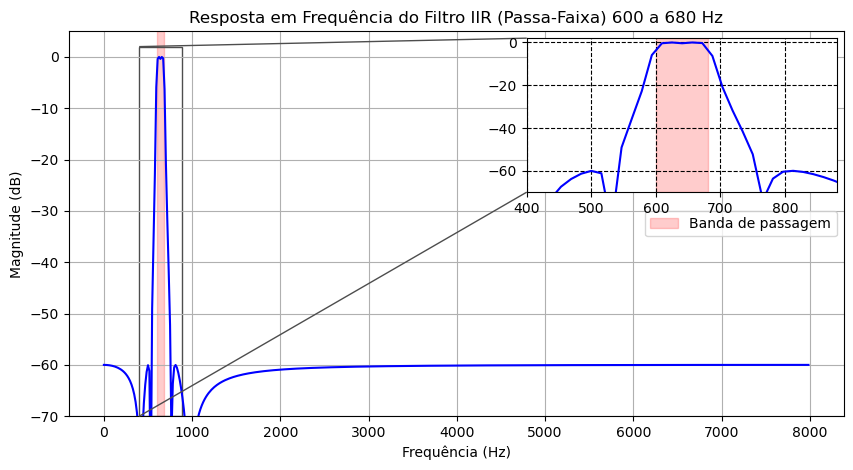

In [65]:
# Frequências normalizadas (0 a 1, onde 1 corresponde a fs/2)
nyq = sample_rate / 2

band = np.array([600, 680])
trans_width = 120 # Quanto maior a faixa de transição melhor o resultado de atenuação na banda de rejeição 
edges = np.array([band[0] - trans_width, band[1] + trans_width])
Ap = 0.4 # Riple da banda de passagem em dB
As = 60 # Atuanção na banda de rejeição

wp = band / (sample_rate/2) # Normalizando a banda de passagem
ws =  edges / (sample_rate/2) # Normalizando as bordas de transição

N, wc = sig.ellipord(wp, ws, Ap, As) # Obtendo a ordem e as frequências de corte

b, a = sig.ellip(N, Ap, As, wc, 'bandpass') # Projetando o filtro

Response_freq_IIR(frequencias[0], b, a, sample_rate, band, edges)

In [66]:
# Convolução no tempo entre os dados de áudio e filtro
cos_filtrado = sig.lfilter(b, a, data)

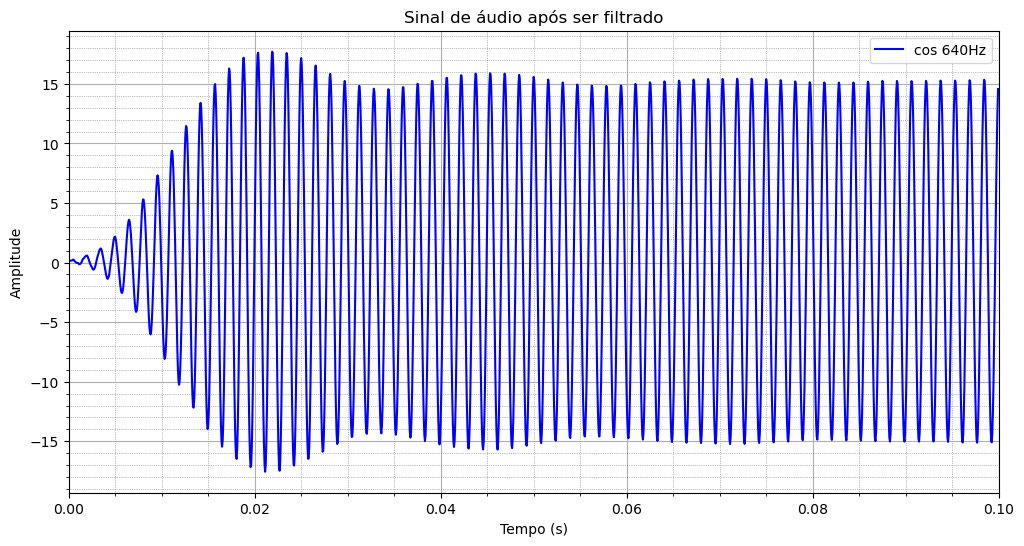

In [67]:
visual_time = 0.1 # Tempo de visualização, pois há muitas amostras para plotar
convolve_filter(frequencias[0], cos_filtrado, visual_time, sample_rate)

In [ ]:
# Método que diminui o atraso causado pelo filtro
# data_filtrado = sig.filtfilt(b, a, data)
# convolve_filter(frequencias[0], data_filtrado, visual_time, sample_rate)

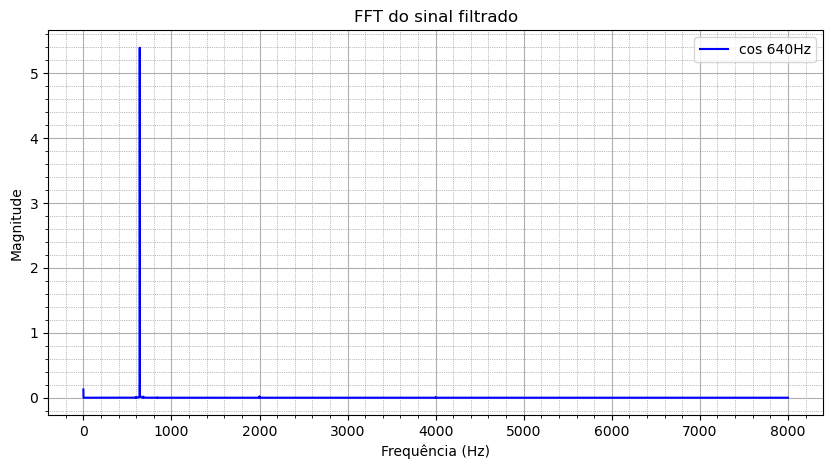

In [25]:
# FFT do Sinal Filtrado
FFT_sinal_filtrado(frequencias[0], cos_filtrado, sample_rate)

## Filtro para atenuar as componentes de 640, 2000 e 4000 Hz
Parâmetros do filtro:
1. Filtro passa faixa;
2. Ripple da banda de passagem 1dB;
3. Faixa de passagem 800 a 880 Hz;
4. Atenuação na banda de rejeição 60 dB

/tmp/ipykernel_4574/1348458991.py:17: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs, width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs.transAxes)


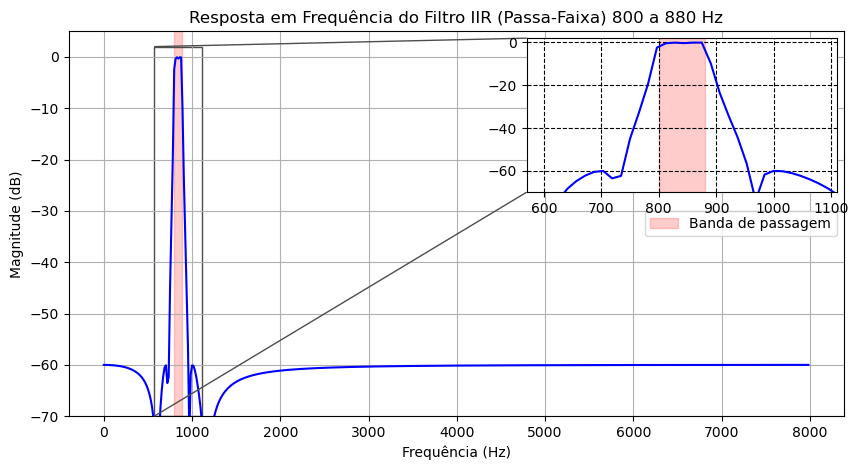

In [59]:
# Frequências normalizadas (0 a 1, onde 1 corresponde a fs/2)
nyq = sample_rate / 2

band = np.array([800, 880])
trans_width = 150 # Quanto maior a faixa de transição melhor o resultado de atenuação na banda de rejeição 
edges = np.array([band[0] - trans_width, band[1] + trans_width])
Ap = 0.4 # Riple da banda de passagem em dB
As = 60 # Atuanção na banda de rejeição

wp = band / (sample_rate/2) # Normalizando a banda de passagem
ws =  edges / (sample_rate/2) # Normalizando as bordas de transição

N, wc = sig.ellipord(wp, ws, Ap, As) # Obtendo a ordem e as frequências de corte

b, a = sig.ellip(N, Ap, As, wc, 'bandpass') # Projetando o filtro

Response_freq_IIR(frequencias[1], b, a, sample_rate, band, edges)

In [60]:
# Convolução no tempo entre os dados de áudio e filtro
cos_filtrado = sig.lfilter(b, a, data)

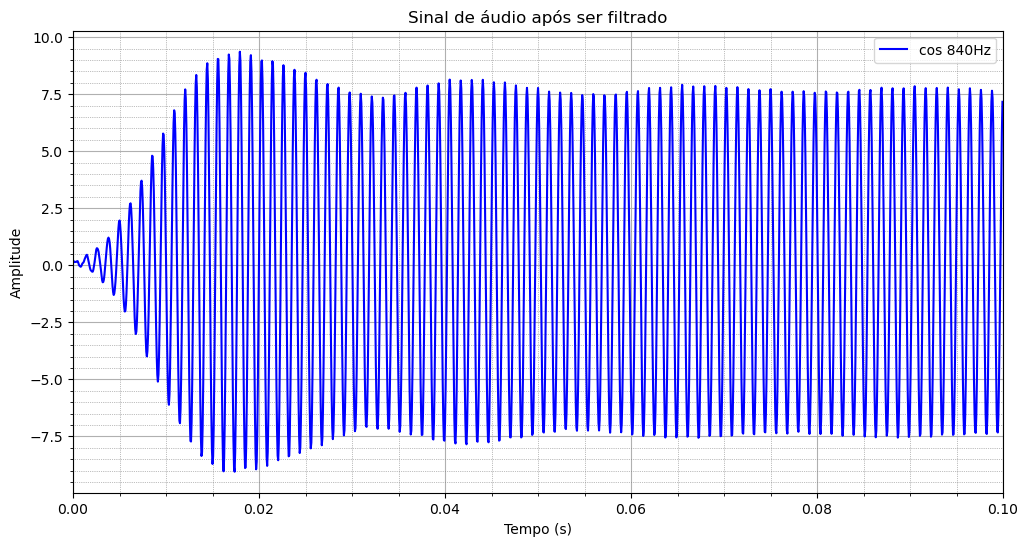

In [61]:
visual_time = 0.1 # Tempo de visualização, pois há muitas amostras para plotar
convolve_filter(frequencias[1], cos_filtrado, visual_time, sample_rate)

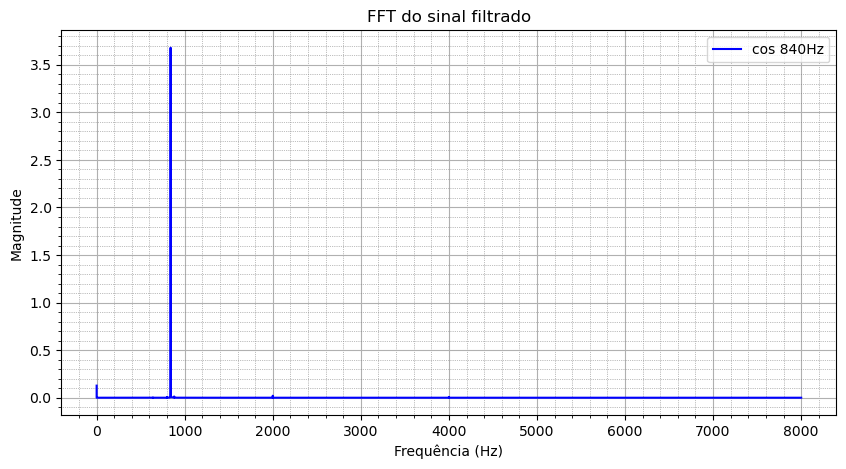

In [30]:
# FFT do Sinal Filtrado
FFT_sinal_filtrado(frequencias[1], cos_filtrado, sample_rate)

## Filtro para atenuar as componentes de 640, 840 e 4000 Hz
Parâmetros do filtro:
1. Filtro passa faixa;
2. Ripple da banda de passagem 1dB;
3. Faixa de passagem 1500 a 2500 Hz;
4. Atenuação na banda de rejeição 60 dB

/tmp/ipykernel_4574/1348458991.py:17: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs, width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs.transAxes)


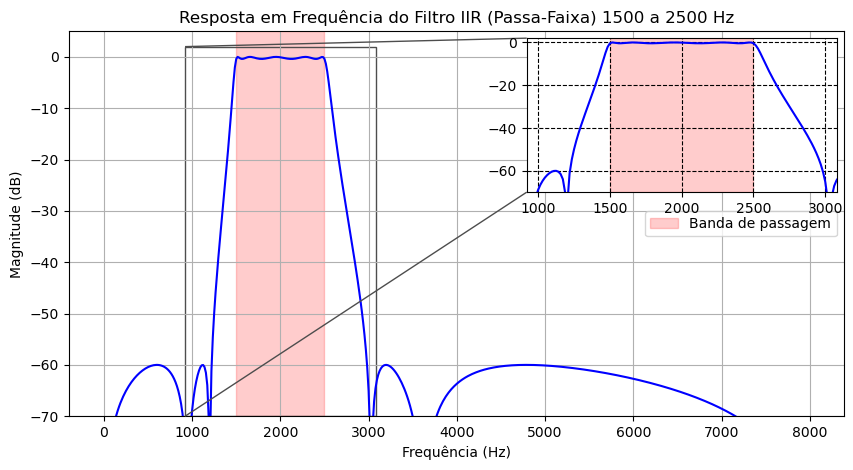

In [31]:
# Frequências normalizadas (0 a 1, onde 1 corresponde a fs/2)
nyq = sample_rate / 2

band = np.array([1500, 2500])
trans_width = 500 # Quanto maior a faixa de transição melhor o resultado de atenuação na banda de rejeição 
edges = np.array([band[0] - trans_width, band[1] + trans_width])
Ap = 0.4 # Riple da banda de passagem em dB
As = 60 # Atuanção na banda de rejeição

wp = band / (sample_rate/2) # Normalizando a banda de passagem
ws =  edges / (sample_rate/2) # Normalizando as bordas de transição

N, wc = sig.ellipord(wp, ws, Ap, As) # Obtendo a ordem e as frequências de corte

b, a = sig.ellip(N, Ap, As, wc, 'bandpass') # Projetando o filtro

Response_freq_IIR(frequencias[2], b, a, sample_rate, band, edges)

In [32]:
# Convolução no tempo entre os dados de áudio e filtro
cos_filtrado = sig.lfilter(b, a, data)

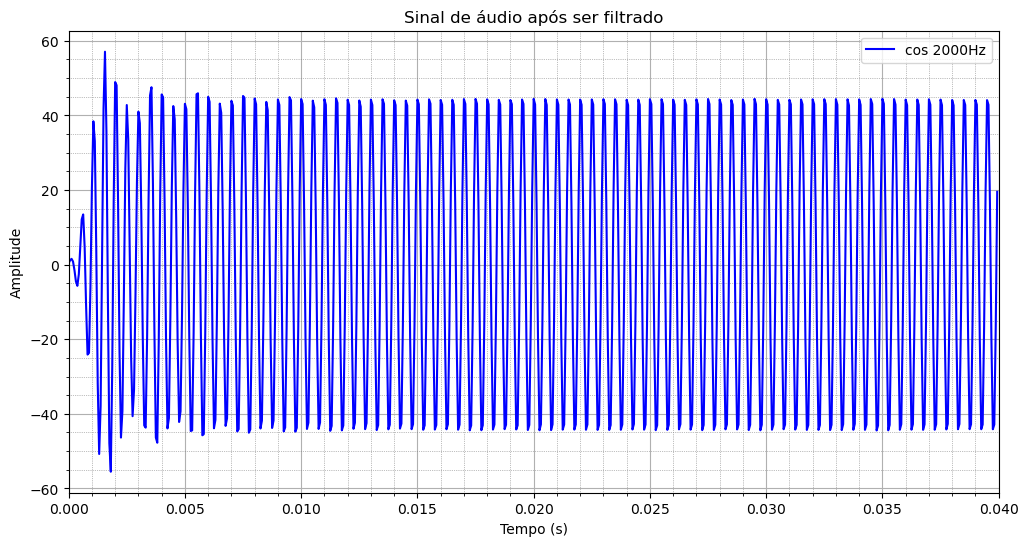

In [33]:
visual_time = 0.04 # Tempo de visualização, pois há muitas amostras para plotar

convolve_filter(frequencias[2], cos_filtrado, visual_time, sample_rate)

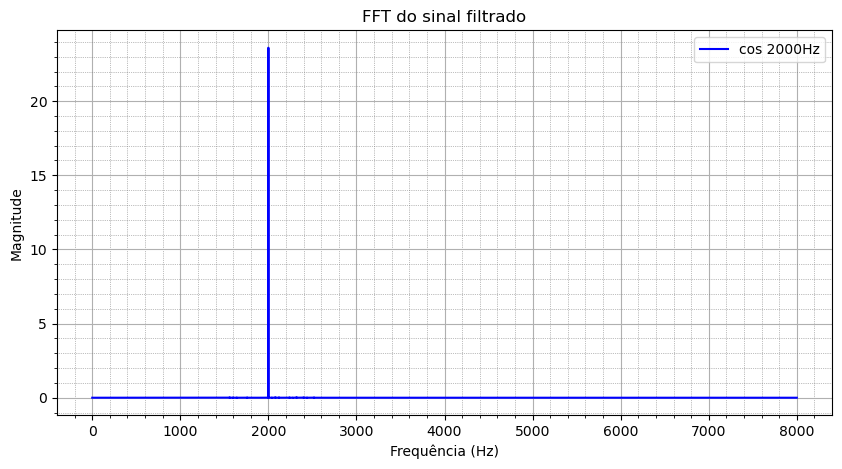

In [34]:
# FFT do Sinal Filtrado
FFT_sinal_filtrado(frequencias[2], cos_filtrado, sample_rate)

## Filtro para atenuar as componentes de 640, 840 e 2000 Hz
Parâmetros do filtro:
1. Filtro passa faixa;
2. Ripple da banda de passagem 1dB;
3. Faixa de passagem 3500 a 4500 Hz;
4. Atenuação na banda de rejeição 60 dB

/tmp/ipykernel_4574/1348458991.py:8: RuntimeWarning: divide by zero encountered in log10
  axs.plot(wz, 20 * np.log10(np.abs(hz)), 'b')
/tmp/ipykernel_4574/1348458991.py:17: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  axins = inset_axes(axs, width=f"{zoom}%", height=f"{zoom}%", loc="upper right", bbox_transform=axs.transAxes)
/tmp/ipykernel_4574/1348458991.py:19: RuntimeWarning: divide by zero encountered in log10
  axins.plot(wz, 20 * np.log10(np.abs(hz)), 'b')


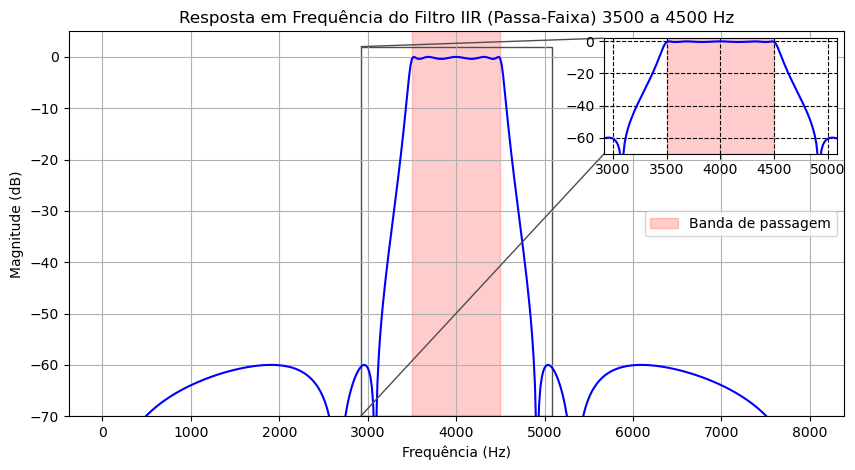

In [36]:
# Frequências normalizadas (0 a 1, onde 1 corresponde a fs/2)
nyq = sample_rate / 2

band = np.array([3500, 4500])
trans_width = 500 # Quanto maior a faixa de transição melhor o resultado de atenuação na banda de rejeição 
edges = np.array([band[0] - trans_width, band[1] + trans_width])
Ap = 0.4 # Riple da banda de passagem em dB
As = 60 # Atuanção na banda de rejeição

wp = band / (sample_rate/2) # Normalizando a banda de passagem
ws =  edges / (sample_rate/2) # Normalizando as bordas de transição

N, wc = sig.ellipord(wp, ws, Ap, As) # Obtendo a ordem e as frequências de corte

b, a = sig.ellip(N, Ap, As, wc, 'bandpass') # Projetando o filtro

Response_freq_IIR(frequencias[3], b, a, sample_rate, band, edges, zoom=30)

In [37]:
# Convolução no tempo entre os dados de áudio e filtro
cos_filtrado = sig.lfilter(b, a, data)

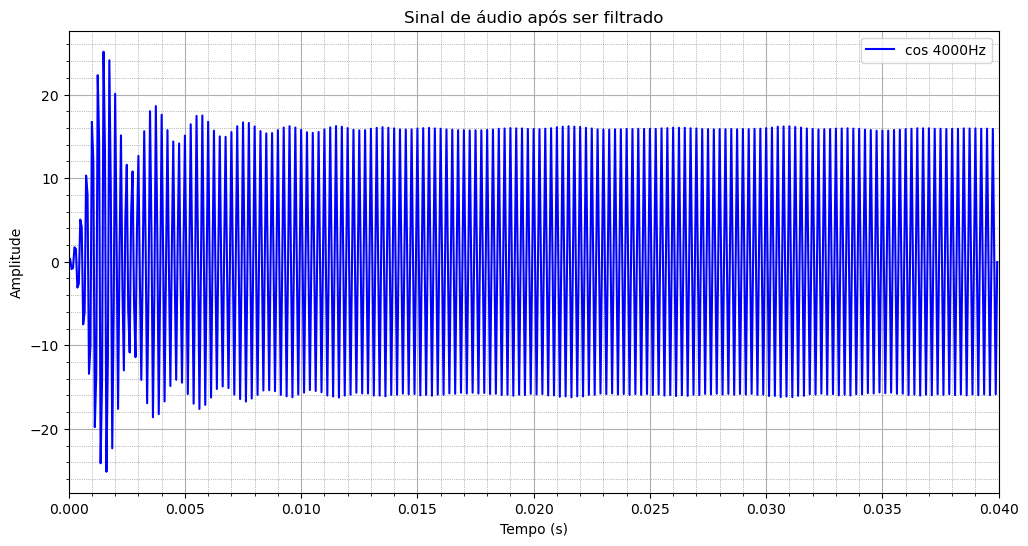

In [38]:
visual_time = 0.04 # Tempo de visualização, pois há muitas amostras para plotar

convolve_filter(frequencias[3], cos_filtrado, visual_time, sample_rate)

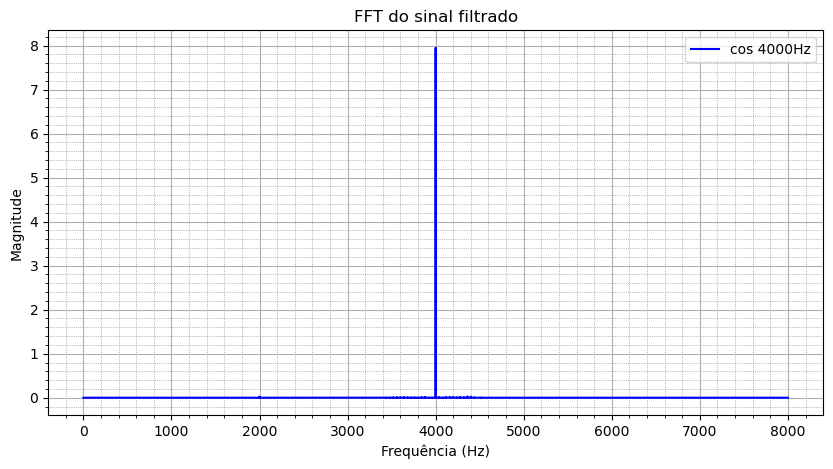

In [39]:
# FFT do Sinal Filtrado
FFT_sinal_filtrado(frequencias[3], cos_filtrado, sample_rate)